<a href="https://colab.research.google.com/github/Mojn2000/DeepProject/blob/main/RNN_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pickle5
import pickle5 as pickle
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

drive_path = 'drive/My Drive/Skole/Uni/9_semester/02456_deep_learning/Project/'

if (not(os.path.exists(drive_path))):
  drive_path = 'drive/MyDrive/DL project/'  # Idas path    

f0 = "padded_data.pickle"

## LOAD PADDED and CLEANED data 
with open(drive_path + f0, 'rb') as f:
    data = pickle.load(f)


     |████████████████████████████████| 256 kB 5.4 MB/s 
Mounted at /content/drive


In [ ]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, leaky_relu, linear 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

Separate into test, train, and bumpy roads 

In [ ]:
# Definition of bumpy road in IRI terms 
tau = 4.5 

good_data = data[data['IRI_mean'] <= tau]
bad_data = data[data['IRI_mean'] > tau]


# Separate good_data into test and train sets 
n = 2500 # sample size of train set

good_train, good_test = train_test_split(good_data, test_size=0.2)
#bad_train, bad_test = train_test_split(bad_data, test_size=0.2)

# Build the model


In [ ]:
train_data = []
test_data = []
test_bad = []

batch_size = 32

# test data
for i in range(len(good_test['GM.acc.xyz.z'])):
   #x_data = np.concatenate((good_test['GM.acc.xyz.z'].values[i].flatten(),good_test['GM.obd.spd_veh.value'].values[i].flatten()),axis=0)
   x_data = good_test['GM.acc.xyz.z'].values[i].flatten()
   labels = [i] * len(x_data)
   test_data.append([x_data, labels])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

# train data
for i in range(len(good_train['GM.acc.xyz.z'])):
   #x_data = np.concatenate((good_train['GM.acc.xyz.z'].values[i].flatten(),good_train['GM.obd.spd_veh.value'].values[i].flatten()),axis=0)
   x_data = good_train['GM.acc.xyz.z'].values[i].flatten()
   labels = [i] * len(x_data)
   train_data.append([x_data, labels])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

# bad data
for i in range(len(bad_data['GM.acc.xyz.z'])):
   #x_data = np.concatenate((bad_data['GM.acc.xyz.z'].values[i].flatten(),bad_data['GM.obd.spd_veh.value'].values[i].flatten()),axis=0)
   x_data = bad_data['GM.acc.xyz.z'].values[i].flatten()
   labels = [i] * len(x_data)
   test_bad.append([x_data, labels])

bad_loader = torch.utils.data.DataLoader(test_bad, shuffle=True, batch_size=batch_size)


i1, l1 = next(iter(train_loader))
print(i1.shape)

torch.Size([32, 3366])


# RNN network

In [ ]:
# define size variables
# num_features = len(good_train['GM.acc.xyz.z'].values[0]) + len(good_train['GM.obd.spd_veh.value'].values[0])
num_features = len(good_train['GM.acc.xyz.z'].values[0])
hidden_units = 24 #40
latent_features = 8 #8

seq_len = 1
n_features = num_features
latent_dim = latent_features
hidden_size = hidden_units


class EncoderRNN(nn.Module):
    def __init__(self, n_features, latent_dim, hidden_size):
      super(EncoderRNN, self).__init__()

      self.n_features = n_features
      self.hidden_size = hidden_size
      self.latent_dim = latent_dim

      self.gru_enc = nn.GRU(n_features, hidden_size,
                        batch_first = True,dropout=0, # tried dropout, not effecttive
                        bidirectional=True)
      
      self.lat_layer = nn.GRU(hidden_size*2, latent_dim,
                        batch_first = True, dropout=0,
                        bidirectional = False)
    
    def forward(self, x):
      x, _  = self.gru_enc(x)
      x , h = self.lat_layer(x)
      return x[:,-1].unsqueeze(1)


class DecoderRNN(nn.Module):
    def __init__(self, seq_len, n_features , latent_dim , hidden_size):
      super(DecoderRNN, self).__init__()

      self.seq_len = seq_len
      self.n_features = n_features
      self.latent_dim = latent_dim
      self.hidden_size = hidden_size

      self.gru_dec1 = nn.GRU(latent_dim, latent_dim,
                      batch_first = True, dropout=0,
                      bidirectional= False)

      self.gru_dec2 = nn.GRU(latent_dim, hidden_size,
                        batch_first = True, dropout=0,
                        bidirectional= True)

      self.output_layer = nn.Linear(self.hidden_size*2, n_features,bias=True)

    def forward(self, x):

      x = x.repeat(1,self.seq_len, 1)
      x, _ = self.gru_dec1(x)
      x, _ = self.gru_dec2(x)
      return (self.output_layer(x))


class AERNN(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim , hidden_size):
      super(AERNN, self).__init__()

      self.seq_len = seq_len
      self.encoder = EncoderRNN(n_features, latent_dim, hidden_size)
      self.decoder = DecoderRNN(seq_len, n_features, latent_dim, hidden_size)

    def forward(self, x):

      x = self.encoder(x)
      x = self.decoder(x)

      return x

net = AERNN(seq_len, n_features, latent_dim , hidden_size)

print(net)


AERNN(
  (encoder): EncoderRNN(
    (gru_enc): GRU(3366, 24, batch_first=True, bidirectional=True)
    (lat_layer): GRU(48, 8, batch_first=True)
  )
  (decoder): DecoderRNN(
    (gru_dec1): GRU(8, 8, batch_first=True)
    (gru_dec2): GRU(8, 24, batch_first=True, bidirectional=True)
    (output_layer): Linear(in_features=48, out_features=3366, bias=True)
  )
)


## Set network parameters

In [ ]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
#optimizer = optim.Adam(net.parameters(), lr=1e-3,weight_decay=1e-4) #weight_decay=1e-2
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3,weight_decay=1e-4) #weight_decay=1e-4

# custom loss function
def loss_function(x_hat,x):

    x_hat[x[:,:,:] == 0] = 0 

    loss = torch.diagonal(torch.matmul(x_hat[:,0,:] - x[:,0,:],torch.transpose(x_hat[:,0,:] - x[:,0,:] ,0,1))) / torch.sum(x[:,0,:] != 0, dim = 1)
    
    return(sum(loss)/batch_size)


In [ ]:
#@title
import os
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from IPython.display import Image, display, clear_output
from sklearn.manifold import TSNE
from torch import Tensor
from torch.distributions import Normal
from torchvision.utils import make_grid


def plot_autoencoder_stats(
        x: Tensor = None,
        x_hat: Tensor = None,
        z: Tensor = None,
        y: Tensor = None,
        epoch: int = None,
        train_loss: List = None,
        valid_loss: List = None,
        classes: List = None,
        dimensionality_reduction_op: Optional[Callable] = None,
) -> None:
    """
    An utility 
    """
    # -- Plotting --
    f, axarr = plt.subplots(2, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("Error")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch + 1), train_loss, color="black")
    ax.plot(np.arange(epoch + 1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training error', 'Validation error'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    # If you want to use a dimensionality reduction method you can use
    # for example TSNE by projecting on two principal dimensions
    # TSNE.fit_transform(z)
    if dimensionality_reduction_op is not None:
        z = dimensionality_reduction_op(z)

    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[y.numpy() == c].T, c=next(colors), marker='o')

    ax.legend(classes)

    # Inputs
    ax = axarr[1, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    rows = 8
    batch_size = x.size(0)
    columns = batch_size // rows

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[1, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x_hat[idx].reshape((28, 28))

    ax.imshow(canvas, cmap='gray')

    tmp_img = "tmp_ae_out.png"
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


def plot_samples(ax, x):
    x = x.to('cpu')
    nrow = int(np.sqrt(x.size(0)))
    x_grid = make_grid(x.view(-1, 1, 28, 28), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


def plot_interpolations(ax, vae):
    device = next(iter(vae.parameters())).device
    nrow = 10
    nsteps = 10
    prior_params = vae.prior_params.expand(2 * nrow, *vae.prior_params.shape[-1:])
    mu, log_sigma = prior_params.chunk(2, dim=-1)
    pz = Normal(mu, log_sigma.exp())
    z = pz.sample().view(nrow, 2, -1)
    t = torch.linspace(0, 1, 10, device=device)
    zs = t[None, :, None] * z[:, 0, None, :] + (1 - t[None, :, None]) * z[:, 1, None, :]
    px = vae.observation_model(zs.view(nrow * nsteps, -1))
    x = px.sample()
    x = x.to('cpu')
    x_grid = make_grid(x.view(-1, 1, 28, 28), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


def plot_grid(ax, vae):
    device = next(iter(vae.parameters())).device
    nrow = 10
    xv, yv = torch.meshgrid([torch.linspace(-3, 3, 10), torch.linspace(-3, 3, 10)])
    zs = torch.cat([xv[:, :, None], yv[:, :, None]], -1)
    zs = zs.to(device)
    px = vae.observation_model(zs.view(nrow * nrow, 2))
    x = px.sample()
    x = x.to('cpu')
    x_grid = make_grid(x.view(-1, 1, 28, 28), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


def plot_2d_latents(ax, qz, z, y):
    z = z.to('cpu')
    y = y.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    palette = sns.color_palette()
    colors = [palette[l] for l in y]

    # plot prior
    prior = plt.Circle((0, 0), scale_factor, color='gray', fill=True, alpha=0.1)
    ax.add_artist(prior)

    # plot data points
    mus, sigmas = qz.mu.to('cpu'), qz.sigma.to('cpu')
    mus = [mus[i].numpy().tolist() for i in range(batch_size)]
    sigmas = [sigmas[i].numpy().tolist() for i in range(batch_size)]

    posteriors = [
        plt.matplotlib.patches.Ellipse(mus[i], *(scale_factor * s for s in sigmas[i]), color=colors[i], fill=False,
                                       alpha=0.3) for i in range(batch_size)]
    for p in posteriors:
        ax.add_artist(p)

    ax.scatter(z[:, 0], z[:, 1], color=colors)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')


def plot_latents(ax, z, y):
    z = z.to('cpu')
    palette = sns.color_palette()
    colors = [palette[l] for l in y]
    z = TSNE(n_components=2).fit_transform(z)
    ax.scatter(z[:, 0], z[:, 1], color=colors)


def make_vae_plots(vae, x, y, outputs, training_data, validation_data, tmp_img="tmp_vae_out.png", figsize=(18, 18)):
    fig, axes = plt.subplots(3, 3, figsize=figsize, squeeze=False)

    # plot the observation
    axes[0, 0].set_title(r'Observation $\mathbf{x}$')
    plot_samples(axes[0, 0], x)

    # plot the latent samples
    try:
        z = outputs['z']
        if z.shape[1] == 2:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
            qz = outputs['qz']
            plot_2d_latents(axes[0, 1], qz, z, y)
        else:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ (t-SNE)')
            plot_latents(axes[0, 1], z, y)
    except Exception as e:
        print(f"Could not generate the plot of the latent sanples because of exception")
        print(e)

    # plot posterior samples
    axes[0, 2].set_title(
        r'Reconstruction $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
    px = outputs['px']
    x_sample = px.sample().to('cpu')
    plot_samples(axes[0, 2], x_sample)

    # plot ELBO
    ax = axes[1, 0]
    ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    ax.plot(training_data['elbo'], label='Training')
    ax.plot(validation_data['elbo'], label='Validation')
    ax.legend()

    # plot KL
    ax = axes[1, 1]
    ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    ax.plot(training_data['kl'], label='Training')
    ax.plot(validation_data['kl'], label='Validation')
    ax.legend()

    # plot NLL
    ax = axes[1, 2]
    ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    ax.plot(training_data['log_px'], label='Training')
    ax.plot(validation_data['log_px'], label='Validation')
    ax.legend()

    # plot prior samples
    axes[2, 0].set_title(r'Samples $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim p(\mathbf{z})$')
    px = vae.sample_from_prior(batch_size=x.size(0))['px']
    x_samples = px.sample()
    plot_samples(axes[2, 0], x_samples)

    # plot interpolations samples
    axes[2, 1].set_title(
        r'Latent Interpolations: $\mathbf{x} \sim p_\theta(\mathbf{x} | t \cdot \mathbf{z}_1 + (1-t) \cdot \mathbf{z}_2), \mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z}), t=0 \dots 1$')
    plot_interpolations(axes[2, 1], vae)

    # plot samples (sampling from a grid instead of the prior)
    if vae.latent_features == 2:
        axes[2, 2].set_title(
            r'Samples: $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim \operatorname{grid}(-3:3, -3:3)$')
        px = vae.sample_from_prior(batch_size=x.size(0))['px']
        x_samples = px.sample()
        plot_grid(axes[2, 2], vae)

    # display
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


## Train the network 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

train_loss = []
valid_loss = []

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x,y in train_loader:
        
        x = x.float()
        #print(x.shape)
        x = x[:,None,:]
        outputs = net(x)
        x_hat = outputs
        #x_hat = outputs['x_hat']
        #x_hat = outputs[:,0,:]
        #x = x[:,0,:]
        #x_hat[x[:,:] == 0] = 0

        # note, target is the original tensor, as we're working with auto-encoders
        optimizer.zero_grad()
        
        loss = loss_function(x_hat, x)

        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        x = x.float()
        x = x[:,None,:]
        outputs = net(x)
        x_hat = outputs

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        #x_hat = outputs['x_hat']
        #x_hat[x[:,:] == 0] = 0

        #z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue
   

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [ ]:
import matplotlib.pyplot as plt
len_epoch = range(len(train_loss))
#len_epoch = len_epoch[0:19]

plt.rcParams.update(plt.rcParamsDefault)

plt.figure(dpi=800)
plt.plot(len_epoch,np.log10(train_loss),color='r',label="Train loss")
plt.plot(len_epoch,np.log10(valid_loss),color='b', label= "Validation loss")
#plt.plot(len_epoch,train_loss,color='r',label="Train loss")
#plt.plot(len_epoch,valid_loss,color='b', label= "Validation loss")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("log(MSE)")
plt.grid()
plt.legend()
plt.show()


In [ ]:
sqerr_good = []
for x,y in test_loader:
  x = x.float()
  x = x[:,None,:]
  outputs = net(x)
  x_hat = outputs#['x_hat']
  x_hat[x==0] = 0
  sqerr_good.extend((torch.diagonal(torch.matmul(x_hat[:,0,:] - x[:,0,:],torch.transpose(x_hat[:,0,:] - x[:,0,:] ,0,1))) / torch.sum(x[:,0,:] != 0, dim = 1)).tolist())
  #for ii in range(x_hat.shape[0]):
  #  sqerr_good.append(float(sum((x[ii,0,x[ii,0,:] != 0] - x_hat[ii,0,x[ii,0,:] != 0])**2)) / sum(x[ii,0,:] != 0))

plt.hist(sqerr_good, bins = 40)
plt.title("Test data")
plt.show()

#print(x.shape)
#print(x_hat.shape)
#print(loss_function(x,x_hat))

In [ ]:
sqerr_bad = []
for x,y in bad_loader:
  x = x.float()
  x = x[:,None,:]
  outputs = net(x)
  x_hat = outputs#['x_hat']
  x_hat[x == 0] = 0
  sqerr_bad.extend((torch.diagonal(torch.matmul(x_hat[:,0,:] - x[:,0,:],torch.transpose(x_hat[:,0,:] - x[:,0,:] ,0,1))) / torch.sum(x[:,0,:] != 0, dim = 1)).tolist())
  #for ii in range(x_hat.shape[0]):
    #sqerr_bad.append(float(sum((x[ii,0,x[ii,0,:] != 0] - x_hat[ii,0,x[ii,0,:] != 0])**2)) / sum(x[ii,0,:] != 0))
    


plt.hist(sqerr_bad, bins = 40)
plt.title("Bad data")
plt.show()

In [ ]:
plt.hist(sqerr_good, bins = 30, alpha=0.5, label='Good')
plt.hist(sqerr_bad, bins = 30, alpha=0.5, label='Bad')
plt.legend(loc='upper right')
plt.title("Network test for good and bad data")
plt.show()

In [ ]:
min(sqerr_good)

0.00039136569830588996

#Compute performance

Tried weight decay -> funky minimum 
Adam -> not as good as RSMprop
Dropout -> also, no performance increase 

In [ ]:
eps = 1e-6
tau_min = min(min(sqerr_good),min(sqerr_bad)) - eps
tau_max = max(max(sqerr_good),max(sqerr_bad)) + eps
print(tau_min)
print(tau_max)

N = 100

perf = np.array([np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)])
ii = 0
for tau in np.linspace(tau_min, tau_max, num = N):
  perf[0,ii] = tau
  perf[1,ii] = sum(sqerr_good<tau)  # true positives
  perf[2,ii] = sum(sqerr_good>=tau) # false positive 
  perf[3,ii] = sum(sqerr_bad<tau)   # false negatives
  perf[4,ii] = sum(sqerr_bad>=tau) # true negatives
  ii += 1

perf = pd.DataFrame(perf)
perf.to_pickle(drive_path+'RNN_v1_1.pickle')

0.0016087823390737177
0.05447471304035187


In [ ]:
def tpr(mat):
  return (perf[1,:]/(perf[1,:]+perf[2,:]))  # TP / (TP+FP)

def tnr(mat):
  return (perf[4,:]/(perf[3,:]+perf[4,:]))  # TN / (TN+FN)

In [ ]:
perf = perf.to_numpy()

In [ ]:
plt.plot(tpr(perf),tnr(perf), marker=".")
plt.plot([0,1],[1,0],linestyle = 'dashed')
plt.xlabel('True positive rate', fontsize = 16)
plt.ylabel('True negative rate',fontsize = 16)
plt.title('Performance curve', fontsize = 20)
plt.grid()
plt.show()

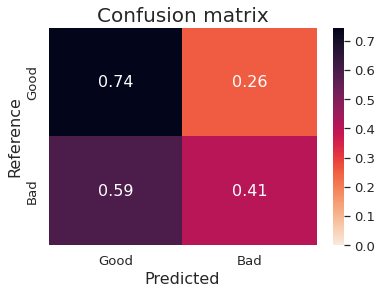

In [ ]:
aux = perf[:,16]
import seaborn as sn

array = [[aux[1]/(aux[1]+aux[2]), aux[2]/(aux[1]+aux[2])],
         [aux[3]/(aux[3]+aux[4]), aux[4]/(aux[3]+aux[4])] ]
#array = array/(sum(aux[1:4]))*100

df_cm = pd.DataFrame(array, ['Good', 'Bad'], ['Good', 'Bad'])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, cmap = sn.cm.rocket_r, annot_kws={"size": 16},vmin = 0, ) # font size
plt.xlabel('Predicted',fontsize = 16)
plt.ylabel('Reference',fontsize = 16)
plt.title('Confusion matrix', fontsize = 20)
plt.show()

In [ ]:
aux

array([2.21001065e-03, 5.27000000e+02, 1.07000000e+02, 2.73000000e+02,
       3.89000000e+02])